In [9]:
!pip install pandas numpy matplotlib seaborn statsmodels scipy``

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached statsmodels-0.14.4-cp310-cp310-macosx_11_0_arm64.whl (9.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 39.6 MB/s eta 0:00:0000:0100:01
  Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)


In [11]:
# Code Block 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('seaborn')

/var/folders/0x/myn1g6jn4gj9ydh__4zqwznw0000gn/T/ipykernel_74636/2927545962.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [12]:
# Code Block 2: Data Loading
def load_price_data():
    files = [
        'prices_round_1_day_-2.csv',
        'prices_round_1_day_-1.csv',
        'prices_round_1_day_0.csv'
    ]
    
    dfs = []
    for file in files:
        df = pd.read_csv(file, sep=';')
        dfs.append(df)
    
    return pd.concat(dfs, ignore_index=True)

df = load_price_data()
print(f"Total number of records: {len(df)}")
print("\nFirst few records:")
df.head()

Total number of records: 90000

First few records:


,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,RAINFOREST_RESIN,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
1,-2,0,KELP,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
2,-2,0,SQUID_INK,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
3,-2,100,SQUID_INK,1999,5,1998.0,26.0,NaN,NaN,2001,20,NaN,NaN,NaN,NaN,2000.0,0.0
4,-2,100,RAINFOREST_RESIN,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0


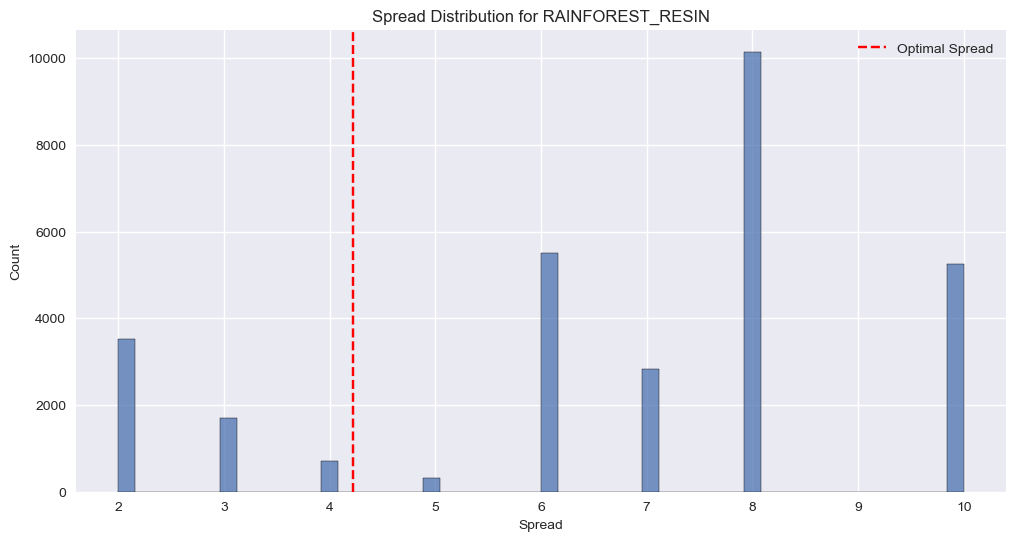

Market Making Analysis for RAINFOREST_RESIN:
Average Spread: 6.77
Optimal Spread (2*Volatility): 4.22
Average Order Book Imbalance: 0.0020
Average Volume: 16.43


In [13]:
# Code Block 3: Market Making Analysis for RAINFOREST_RESIN
def analyze_market_making(product='RAINFOREST_RESIN'):
    product_df = df[df['product'] == product].copy()
    
    # Calculate spread statistics
    product_df['spread'] = product_df['ask_price_1'] - product_df['bid_price_1']
    
    # Calculate order book imbalance
    product_df['imbalance'] = (product_df['bid_volume_1'] - product_df['ask_volume_1']) / \
                             (product_df['bid_volume_1'] + product_df['ask_volume_1'])
    
    # Calculate price changes
    product_df['price_change'] = product_df['mid_price'].diff()
    
    # Calculate optimal spread based on volatility
    volatility = product_df['price_change'].std()
    optimal_spread = 2 * volatility
    
    # Plot spread distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(product_df['spread'], bins=50)
    plt.axvline(optimal_spread, color='r', linestyle='--', label='Optimal Spread')
    plt.title(f'Spread Distribution for {product}')
    plt.xlabel('Spread')
    plt.legend()
    plt.show()
    
    print(f"Market Making Analysis for {product}:")
    print(f"Average Spread: {product_df['spread'].mean():.2f}")
    print(f"Optimal Spread (2*Volatility): {optimal_spread:.2f}")
    print(f"Average Order Book Imbalance: {product_df['imbalance'].mean():.4f}")
    print(f"Average Volume: {product_df['bid_volume_1'].mean() + product_df['ask_volume_1'].mean():.2f}")
    
    return product_df, optimal_spread

resin_df, optimal_spread = analyze_market_making()

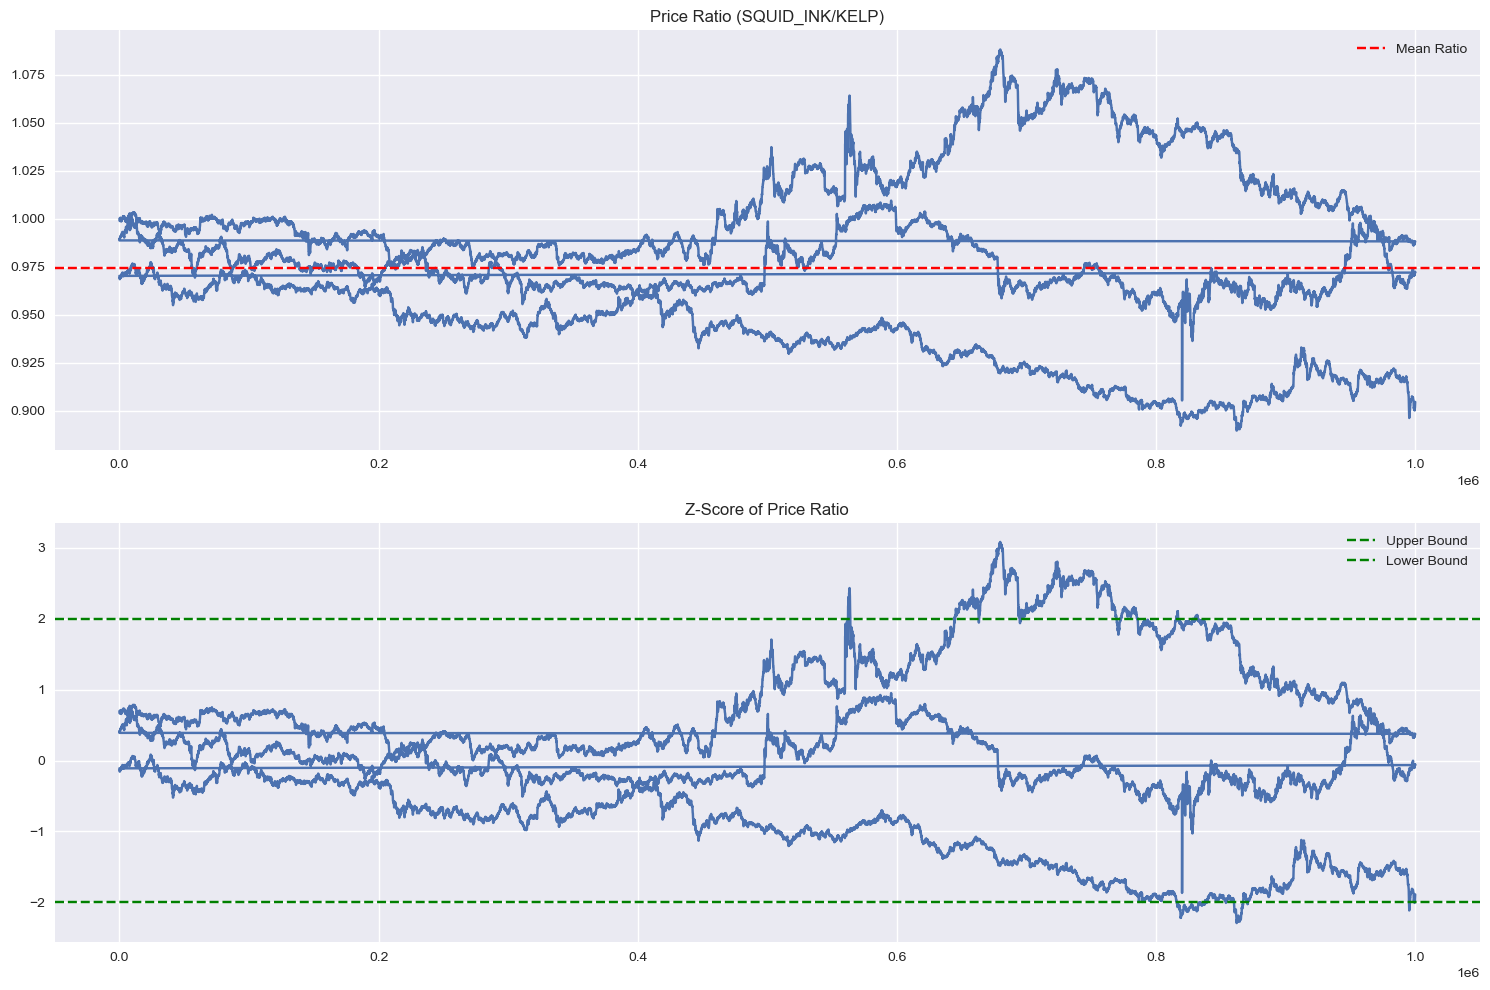

Pairs Trading Analysis:
Mean Price Ratio: 0.9743
Standard Deviation of Ratio: 0.0369
Number of Trading Opportunities (|z-score| > 2): 1718


In [14]:
# Code Block 4: Pairs Trading Analysis
def analyze_pairs_trading():
    pivot_df = df.pivot_table(
        index=['day', 'timestamp'],
        columns='product',
        values='mid_price'
    ).reset_index()
    
    products = ['SQUID_INK', 'KELP']
    
    # Calculate price ratio
    pivot_df['price_ratio'] = pivot_df['SQUID_INK'] / pivot_df['KELP']
    
    # Calculate z-score of price ratio
    mean_ratio = pivot_df['price_ratio'].mean()
    std_ratio = pivot_df['price_ratio'].std()
    pivot_df['z_score'] = (pivot_df['price_ratio'] - mean_ratio) / std_ratio
    
    # Plot price ratio and z-score
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    ax1.plot(pivot_df['timestamp'], pivot_df['price_ratio'])
    ax1.axhline(mean_ratio, color='r', linestyle='--', label='Mean Ratio')
    ax1.set_title('Price Ratio (SQUID_INK/KELP)')
    ax1.legend()
    
    ax2.plot(pivot_df['timestamp'], pivot_df['z_score'])
    ax2.axhline(2, color='g', linestyle='--', label='Upper Bound')
    ax2.axhline(-2, color='g', linestyle='--', label='Lower Bound')
    ax2.set_title('Z-Score of Price Ratio')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("Pairs Trading Analysis:")
    print(f"Mean Price Ratio: {mean_ratio:.4f}")
    print(f"Standard Deviation of Ratio: {std_ratio:.4f}")
    print(f"Number of Trading Opportunities (|z-score| > 2): {len(pivot_df[abs(pivot_df['z_score']) > 2])}")
    
    return pivot_df, mean_ratio, std_ratio

pairs_df, mean_ratio, std_ratio = analyze_pairs_trading()

In [16]:
# Code Block 5: Seasonal Decomposition
def analyze_seasonality(product='RAINFOREST_RESIN'):
    product_df = df[df['product'] == product].copy()
    
    # Resample to regular intervals
    product_df['datetime'] = pd.to_datetime(product_df['timestamp'], unit='ms')
    product_df.set_index('datetime', inplace=True)
    resampled = product_df['mid_price'].resample('100ms').mean()
    
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(resampled, period=100, extrapolate_trend='freq')
    
    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
    
    decomposition.observed.plot(ax=ax1)
    ax1.set_title('Observed')
    
    decomposition.trend.plot(ax=ax2)
    ax2.set_title('Trend')
    
    decomposition.seasonal.plot(ax=ax3)
    ax3.set_title('Seasonal')
    
    decomposition.resid.plot(ax=ax4)
    ax4.set_title('Residual')
    
    plt.tight_layout()
    plt.show()
    
    # Perform Augmented Dickey-Fuller test
    result = adfuller(resampled.dropna())
    print(f"ADF Statistic for {product}: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    
    return decomposition

decomposition = analyze_seasonality()

KeyboardInterrupt: 

In [17]:
# Code Block 6: Optimal Trading Parameters
def calculate_optimal_parameters():
    resin_volatility = resin_df['price_change'].std()
    optimal_spread = 2 * resin_volatility
    
    z_score_threshold = 2.0
    resin_position_size = 10
    pairs_position_size = 5
    
    print("Optimal Trading Parameters:")
    print(f"\nMarket Making (RAINFOREST_RESIN):")
    print(f"- Optimal Spread: {optimal_spread:.2f}")
    print(f"- Position Size: {resin_position_size}")
    print(f"- Volatility Threshold: {resin_volatility:.2f}")
    
    print(f"\nPairs Trading (SQUID_INK/KELP):")
    print(f"- Z-Score Threshold: {z_score_threshold}")
    print(f"- Position Size: {pairs_position_size}")
    print(f"- Mean Ratio: {mean_ratio:.4f}")
    print(f"- Standard Deviation: {std_ratio:.4f}")
    
    return {
        'market_making': {
            'spread': optimal_spread,
            'position_size': resin_position_size,
            'volatility_threshold': resin_volatility
        },
        'pairs_trading': {
            'z_score_threshold': z_score_threshold,
            'position_size': pairs_position_size,
            'mean_ratio': mean_ratio,
            'std_ratio': std_ratio
        }
    }

optimal_params = calculate_optimal_parameters()

Optimal Trading Parameters:

Market Making (RAINFOREST_RESIN):
- Optimal Spread: 4.22
- Position Size: 10
- Volatility Threshold: 2.11

Pairs Trading (SQUID_INK/KELP):
- Z-Score Threshold: 2.0
- Position Size: 5
- Mean Ratio: 0.9743
- Standard Deviation: 0.0369
